In [41]:
from sklearn.datasets import load_boston
from sklearn.ensemble import IsolationForest
from sklearn.impute import SimpleImputer
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm 
from matplotlib import pyplot as plt
from scipy import stats
from scipy.stats import boxcox
from scipy.stats import yeojohnson

In [39]:
# Load data 
x, y = load_boston(return_X_y=True)
boston = load_boston()
columns = boston.feature_names
df = pd.DataFrame(x, columns = columns)
df

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33
...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.06263,0.0,11.93,0.0,0.573,6.593,69.1,2.4786,1.0,273.0,21.0,391.99,9.67
502,0.04527,0.0,11.93,0.0,0.573,6.120,76.7,2.2875,1.0,273.0,21.0,396.90,9.08
503,0.06076,0.0,11.93,0.0,0.573,6.976,91.0,2.1675,1.0,273.0,21.0,396.90,5.64
504,0.10959,0.0,11.93,0.0,0.573,6.794,89.3,2.3889,1.0,273.0,21.0,393.45,6.48


# Outliers Detection

In [3]:
# Robust Z-score
def Robust_zscore(df):
    med = df.median()
    mad = stats.median_abs_deviation(df)
    zscore = (0.6745*(df-med))/mad
    outler = zscore[zscore > 3]
    return outler

In [4]:
outler = Robust_zscore(df['DIS'])
outler

56     3.124045
64     3.142486
254    3.141128
255    3.141128
286    3.072641
351    3.919508
352    3.919508
353    4.659334
354    3.854416
355    3.854416
Name: DIS, dtype: float64

In [5]:
# IQR method
def IQR_outliers(df):
    q1 = df.quantile(0.25)
    q3 = df.quantile(0.75)
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    outler = df[(df > upper)|(df < lower)]
    return outler

In [6]:
IQR_outliers(df['DIS'])

351    10.7103
352    10.7103
353    12.1265
354    10.5857
355    10.5857
Name: DIS, dtype: float64

In [7]:
# Isolation Forest
model = IsolationForest(max_features = 1, n_estimators = 50, contamination = 'auto', random_state = 1)
model.fit(df[['DIS']])
df['score']=model.decision_function(df[['DIS']])
df['anomaly']=model.predict(df[['DIS']])
anomaly = df[['DIS', 'score', 'anomaly']]
anomaly[anomaly['anomaly'] == -1]

,DIS,score,anomaly
1,4.9671,-0.053208,-1
2,4.9671,-0.053208,-1
3,6.0622,-0.011583,-1
4,6.0622,-0.011583,-1
5,6.0622,-0.011583,-1
...,...,...,...
410,1.4130,-0.027557,-1
411,1.5275,-0.007373,-1
412,1.5539,-0.012464,-1
414,1.6582,-0.009389,-1


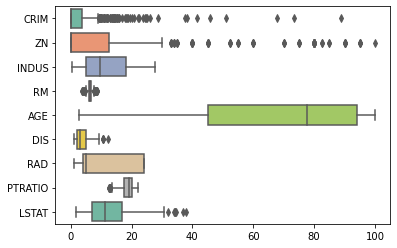

In [8]:
# box plot
df_2 = df[['CRIM', 'ZN', 'INDUS', 'RM', 'AGE', 'DIS', 'RAD', 'PTRATIO','LSTAT']]
ax = sns.boxplot(data=df_2, orient="h", palette="Set2")

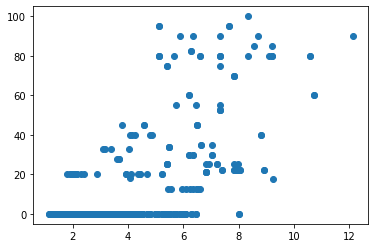

In [9]:
# Scatter plot
plt.scatter(df['DIS'],df['ZN'])

(array([372.,  12.,  48.,  16.,  13.,   6.,   4.,   6.,  19.,  10.]),
 array([  0.,  10.,  20.,  30.,  40.,  50.,  60.,  70.,  80.,  90., 100.]),
 <BarContainer object of 10 artists>)

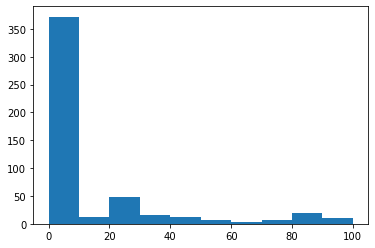

In [10]:
#Hist Plot
plt.hist(df['ZN'])

C:\Users\Joe.Lee\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='DIS', ylabel='Density'>

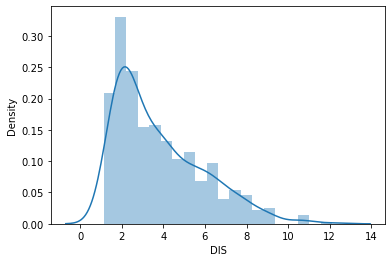

In [11]:
# Dist Plot
sns.distplot(df['DIS'], bins=20)

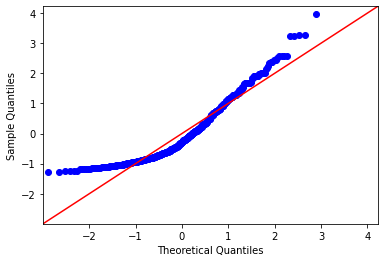

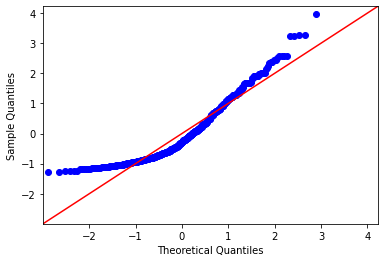

In [20]:
# QQ Plot
sm.qqplot(df['DIS'], line = '45', fit = True) 

# Handling Outliers

Text(0.5, 0, 'DIS trans')

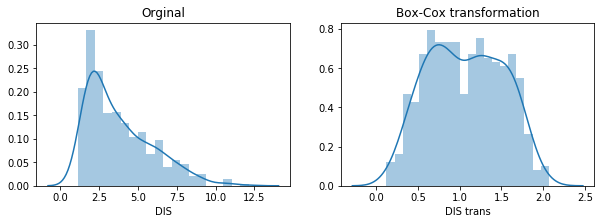

In [36]:
# Box-Cox Transformation
bcx_DIS, lam = boxcox(df['DIS'])

plt.figure(figsize=(10, 3))

plt.subplot(121)
sns.distplot(df['DIS'], bins=20)
plt.title('Orginal')

plt.subplot(122)
sns.distplot(bcx_DIS, bins=20)
plt.title('Box-Cox transformation')
plt.xlabel('DIS trans')

Text(0.5, 0, 'ZN trans')

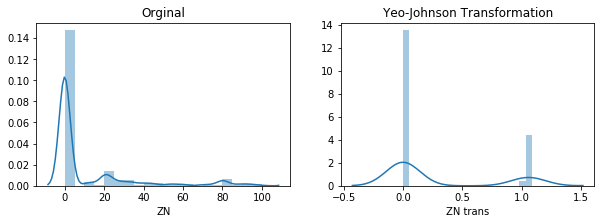

In [37]:
# Yeo-Johnson Transformation
bcx_ZN, lam = yeojohnson(df['ZN'])

plt.figure(figsize=(10, 3))

plt.subplot(121)
sns.distplot(df['ZN'], bins=20)
plt.title('Orginal')

plt.subplot(122)
sns.distplot(bcx_ZN, bins=20)
plt.title('Yeo-Johnson Transformation')
plt.xlabel('ZN trans')

# Handling Missing values

In [44]:
# Mean
data = np.array([[1, 2], [np.nan, 3], [7, 6]])
print(data)
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
data = imp.fit_transform(data)
print(data)

[[ 1.  2.]
 [nan  3.]
 [ 7.  6.]]
[[1. 2.]
 [4. 3.]
 [7. 6.]]


In [46]:
# Median
data = np.array([[1, 2], [np.nan, 3], [7, 6], [2, 8]])
print(data)
imp = SimpleImputer(missing_values=np.nan, strategy='median')
data = imp.fit_transform(data)
print(data)

[[ 1.  2.]
 [nan  3.]
 [ 7.  6.]
 [ 2.  8.]]
[[1. 2.]
 [2. 3.]
 [7. 6.]
 [2. 8.]]


In [48]:
# most_frequent
data = np.array([[1, 2], [np.nan, 3], [7, 6], [7, 8]])
print(data)
imp = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
data = imp.fit_transform(data)
print(data)

[[ 1.  2.]
 [nan  3.]
 [ 7.  6.]
 [ 7.  8.]]
[[1. 2.]
 [7. 3.]
 [7. 6.]
 [7. 8.]]


In [50]:
# particular value
data = np.array([[1, 2], [np.nan, 3], [7, 6], [2, 8]])
print(data)
imp = SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=5)
data = imp.fit_transform(data)
print(data)

[[ 1.  2.]
 [nan  3.]
 [ 7.  6.]
 [ 2.  8.]]
[[1. 2.]
 [5. 3.]
 [7. 6.]
 [2. 8.]]
